# Modèle sur mesure avancé

In [1]:
import re
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Maths modules
from scipy.stats import f_oneway
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
# precision, recall, f1-score,
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenizers, Stemmers and Lemmatizers
import nltk
from nltk.corpus import stopwords
import spacy
# Download resources
nltk.download("stopwords")
stopwords = set(stopwords.words("english"))
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, Embedding, Bidirectional
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

# tuning hyp parameters
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperModel

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\doly9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def analyse_performance_model(model,X,y,title_dataset):
    y_pred_proba = model.predict(X)
    y_pred = np.where(y_pred_proba> 0.5, 1, 0)
    cf = confusion_matrix(y, y_pred)
    plt.figure()
    make_confusion_matrix(cf, categories=['NEGATIVE', 'POSITIVE'], title="Performance du modèle sur le "+title_dataset)
    plt.figure()
    plot_roc_curve(y_pred_proba,y,title='Courbe ROC sur le ' + title_dataset)
    
def plot_roc_curve(y_pred_proba,y_true,title=None):
    #define metrics
    auc = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)
    #create ROC curve
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.title(title)

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Charger des données nettoyées à partir d'un fichier CSV

In [3]:
df = pd.read_csv('D:/openclassroom/projet7/input/df_cleaned_docs.csv',encoding='ISO-8859-1')

In [4]:
df.shape

(1597489, 3)

In [5]:
df.head()

,target,text,clean_text
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccom awww s bummer should...
1,NEGATIVE,is upset that he can't update his Facebook by ...,upset not update facebook texte cry result sch...
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...,kenichan dive time ball manage save rest bound
3,NEGATIVE,my whole body feels itchy and like its on fire,body feel itchy like fire
4,NEGATIVE,"@nationwideclass no, it's not behaving at all....",nationwideclass behave m mad not


In [6]:
# split text column into lists of words
df["tokenized_tweet"] = df['clean_text'].str.split()

In [7]:
df.head()

,target,text,clean_text,tokenized_tweet
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccom awww s bummer should...,"[switchfoot, httptwitpiccom, awww, s, bummer, ..."
1,NEGATIVE,is upset that he can't update his Facebook by ...,upset not update facebook texte cry result sch...,"[upset, not, update, facebook, texte, cry, res..."
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...,kenichan dive time ball manage save rest bound,"[kenichan, dive, time, ball, manage, save, res..."
3,NEGATIVE,my whole body feels itchy and like its on fire,body feel itchy like fire,"[body, feel, itchy, like, fire]"
4,NEGATIVE,"@nationwideclass no, it's not behaving at all....",nationwideclass behave m mad not,"[nationwideclass, behave, m, mad, not]"


In [ ]:
df.shape

## Encodage en entiers des documents
Cela permet de préparer les données textuelles pour une utilisation dans un modèle Keras pour la classification de texte.

In [8]:
#Converting all tokenized words into constant numbers
texts = df['clean_text']
tokenizer = Tokenizer(nb_words=14225)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

C:\Users\doly9\Anaconda3\envs\envproject7_tf12\Lib\site-packages\keras\preprocessing\text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


In [9]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 697834 unique tokens.


In [10]:
#Pad the dataset with 0 in the missing spaces 
data = pad_sequences(sequences, maxlen=30)
data_length = data.shape[1]
labels = df['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1597489, 30)
Shape of label tensor: (1597489,)


## Entraînement du modèle Word2Vec

In [11]:
embedding_dim = 100

In [12]:
# training the model on clean and tokenized tweets
model_word2Vec = Word2Vec(df.tokenized_tweet, vector_size = embedding_dim, window = 20, min_count = 2, negative = 20)

In [13]:
#Intisiating the words vocabulary
word_vectors = model_word2Vec.wv

In [14]:
#Saving the model we created
#model.wv.save_word2vec_format('Word_2_Vec_sentiment_analysis.txt', binary=False)

In [15]:
#Exploring similarity between words to test our model
word_vectors.similar_by_word("hate")

[('stupid', 0.7441415786743164),
 ('dislike', 0.6328375935554504),
 ('ugh', 0.621342658996582),
 ('ridiculous', 0.5821095108985901),
 ('suck', 0.5782181620597839),
 ('curse', 0.5778875946998596),
 ('piss', 0.5485292077064514),
 ('grrrrr', 0.5450734496116638),
 ('grr', 0.5411969423294067),
 ('annoying', 0.5384683012962341)]

## GLOVE

In [16]:
#GloVe Word Embeddings
#Ici, nous chargeons le fichier glove.6B.100d.txt qui contient les embeddings pré-entraînés pour 400 000 mots anglais. Nous parcourons chaque ligne du fichier et extrayons le mot et son vecteur d'embedding associé. Nous stockons ces embeddings dans un dictionnaire appelé embeddings_index.

embedding_dim = 100
embeddings_index = {}
glove_path = os.path.join("..", "inputs")

with open(glove_path+'/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
embedding_dim = 100
embeddings_index = {}
glove_path = os.path.join("..", "inputs")

In [17]:
with open(glove_path+'/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [18]:
#Maintenant, nous allons créer notre matrice d'embedding :
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Séparer un jeu de données en un jeu d'entraînement, un jeu de validation et un jeu de test

In [19]:
X = data
y = df['target'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# Séparer le jeu de données en un jeu d'entraînement (70%), un jeu de validation (20%) et un jeu de test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val,X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

# Vérifier la taille des jeux de données
print("Taille du jeu d'entraînement :", X_train.shape)
print("Taille du jeu de validation :", X_val.shape)
print("Taille du jeu de test :", X_test.shape)

Taille du jeu d'entraînement : (1118242, 30)
Taille du jeu de validation : (321095, 30)
Taille du jeu de test : (158152, 30)


## Hyperparameter tuning for models.

Pour créer une couche d'embedding dans un modèle Keras pour la classification de texte, on utilise les vecteurs de mots appris à partir d'un modèle Word2Vec entraîné sur un corpus de textes.

- input_dim : la taille du vocabulaire du modèle Word2Vec

- output_dim :  la taille de chaque vecteur de mots du modèle Word2Vec

- Les weights sont initialisés avec les vecteurs de mots appris par le modèle Word2Vec, 

- Le paramètre trainable=False signifie que ces poids ne seront pas mis à jour pendant l'entraînement du modèle Keras (car les vecteurs ont déjà été appris par le modèle Word2Vec).

Cette couche d'embedding est utilisée pour transformer les séquences de mots d'un texte en vecteurs denses de dimension output_dim, qui sont ensuite utilisés pour entraîner un modèle de classification de texte

class MyHyperModel(HyperModel):

    def __init__(self, name_model, layer_embedding):
        self.name_model = name_model
        self.layer_embedding = layer_embedding

    def build(self, hp):
        model_nn = Sequential(name=self.name_model)
        model_nn.add(self.layer_embedding)
        #e = Embedding(input_dim=model_word2Vec.wv.vectors.shape[0], output_dim=model_word2Vec.wv.vectors.shape[1], weights=[model_word2Vec.wv.vectors], trainable=False)
        #model_nn.add(e)
        model_nn.add(LSTM(units=hp.Int('units_lstm', min_value=20, max_value=100, step=20), dropout=0.2))
        model_nn.add(Dense(units=hp.Int('units_dense_', min_value=10, max_value=50, step=20),activation='relu'))
        model_nn.add(Dense(1, activation='sigmoid'))
        model_nn.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
        return model_nn

class MyHyperModel(HyperModel):

    def __init__(self, name_model, layer_embedding):
        self.name_model = name_model
        self.layer_embedding = layer_embedding

    def build(self, hp):
        model_nn = Sequential(name=self.name_model)
        model_nn.add(self.layer_embedding)
        #e = Embedding(input_dim=model_word2Vec.wv.vectors.shape[0], output_dim=model_word2Vec.wv.vectors.shape[1], weights=[model_word2Vec.wv.vectors], trainable=False)
        #model_nn.add(e)
        model_nn.add(LSTM(units=hp.Int('units_lstm', min_value=20, max_value=100, step=20), dropout=0.2))
        model_nn.add(Dense(units=hp.Int('units_dense_', min_value=10, max_value=50, step=20),activation='relu'))
        model_nn.add(Dense(1, activation='sigmoid'))
        model_nn.compile(optimizer=hp.Choice('optimizer', values= ['Adam', 'Adadelta']),
                    loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
        return model_nn

In [23]:
class MyHyperModel(HyperModel):

    def __init__(self, name_model, layer_embedding,type_model):
        self.name_model = name_model
        self.layer_embedding = layer_embedding
        self.type_model = type_model

    def build(self, hp):
        model_nn = Sequential(name=self.name_model)
        model_nn.add(self.layer_embedding)
        if (self.type_model=='LSTM'):
            model_nn.add(LSTM(units=hp.Int('units_lstm', min_value=20, max_value=100, step=20), dropout=0.2))
        if (self.type_model=='BidirectionalLSTM'):
            model_nn.add(Bidirectional(LSTM(units=hp.Int('units_lstm', min_value=20, max_value=100, step=20), dropout=0.2)))
        model_nn.add(Dense(units=hp.Int('units_dense_', min_value=10, max_value=50, step=20),activation='relu'))
        model_nn.add(Dense(1, activation='sigmoid'))
        model_nn.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
        return model_nn

In [41]:
word2vec_layer =Embedding(input_dim=model_word2Vec.wv.vectors.shape[0], output_dim=model_word2Vec.wv.vectors.shape[1], weights=[model_word2Vec.wv.vectors], trainable=False)
#hypermodel = MyHyperModel("lstm_word2vec_embedding", word2vec_layer,"LSTM")
hypermodel = MyHyperModel("bilstm_word2vec_embedding", word2vec_layer,"BidirectionalLSTM")

tuner = BayesianOptimization(hypermodel, objective='val_accuracy', max_trials=10, overwrite=True)
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=1024)


Trial 10 Complete [00h 43m 44s]
val_accuracy: 0.7609710693359375

Best val_accuracy So Far: 0.7651878595352173
Total elapsed time: 05h 50m 09s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Hyperparamer tuner
#glove_layer = Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)
#glove_hypermodel = MyHyperModel("lstm_glove_embedding", glove_layer,"LSTM")
#glove_tuner = BayesianOptimization(glove_hypermodel, objective='val_accuracy', max_trials=10)
#glove_tuner.search(X_train, y_train, epochs=3, validation_data=(X_val, y_val), batch_size=1024)


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)
best_model.summary()

In [ ]:
# save the best model
results_data_path = os.path.join("..", "outputs")
model_save_path = os.path.join(results_data_path, "best_word2vec_lstm.h5")
best_model.save(model_save_path)

## Entrainement de modèle avec les meilleurs hyperparametères 

In [46]:

def create_model(name_model,type_model,layer_embedding,units_lstm,units_dense,opt):
    model_nn = Sequential(name=name_model)
    model_nn.add(layer_embedding)
    if (type_model=='LSTM'):
        model_nn.add(LSTM(units=units_lstm, dropout=0.2))
    if (type_model=='BidirectionalLSTM'):
        model_nn.add(Bidirectional(LSTM(units=units_lstm, dropout=0.2)))
    model_nn.add(Dense(units=units_dense,activation='relu'))
    model_nn.add(Dense(1, activation='sigmoid'))
    print(model_nn.summary())
    model_nn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', AUC(curve="ROC", name="ROC_AUC")])
    return model_nn

def train_model(model,epochs,batch_size,save_interval):
    checkpoint_callback = ModelCheckpoint(filepath=os.path.join("..", "saved_models")+'/'+model.name+'/'+model.name+'_epoch_{epoch:02d}.h5', save_freq=save_interval)
    tensorboard_callback = TensorBoard(log_dir=os.path.join("..", "logs")+'/'+model.name)
    history = model_nn.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=epochs, batch_size=batch_size, callbacks=[tensorboard_callback, checkpoint_callback])


In [47]:
name_model = "word2vec_bilstm"
type_model ="BidirectionalLSTM"
#layer_embedding = Embedding(input_dim=model_word2Vec.wv.vectors.shape[0], output_dim=model_word2Vec.wv.vectors.shape[1], weights=[model_word2Vec.wv.vectors], trainable=False)
layer_embedding =  Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)
units_lstm = 100
units_dense = 10
opt = "adam"
epoch = 30
batch_size = 1024
save_interval = 5
model_nn = create_model(name_model,type_model,layer_embedding,units_lstm,units_dense,opt)
train_model(model_nn,epoch,batch_size,save_interval)

Model: "word2vec_bilstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         69783500  
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 10)                2010      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 69,946,321
Trainable params: 162,821
Non-trainable params: 69,783,500
_________________________________________________________________
None
Epoch 1/30
1093/1093 [==============================] - 580s 525ms/step - loss: 0.5314 - accur

**Continue training a saved model from a specific epoch**

In [29]:
# load model
from keras.models import load_model
# Load the saved model
save_interval=5
model = load_model(os.path.join("..", "saved_models/glove_lstm/")+'glove_lstm_epoch_05.h5')
checkpoint_callback = ModelCheckpoint(filepath=os.path.join("..", "saved_models")+'/'+model.name+'/'+model.name+'_epoch_{epoch:02d}.h5', save_freq=save_interval)
tensorboard_callback = TensorBoard(log_dir=os.path.join("..", "logs")+'/'+model.name)
# Set the epoch number to start training from
initial_epoch = 5
# Continue training the model from initial_epoch 
model.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_val, y_val), initial_epoch=initial_epoch,callbacks=[tensorboard_callback, checkpoint_callback])


Epoch 6/50
1093/1093 [==============================] - 287s 261ms/step - loss: 0.4846 - accuracy: 0.7643 - ROC_AUC: 0.8463 - val_loss: 0.4827 - val_accuracy: 0.7660 - val_ROC_AUC: 0.8527
Epoch 7/50
1093/1093 [==============================] - 284s 260ms/step - loss: 0.4820 - accuracy: 0.7659 - ROC_AUC: 0.8482 - val_loss: 0.4727 - val_accuracy: 0.7728 - val_ROC_AUC: 0.8553
Epoch 8/50
1093/1093 [==============================] - 297s 272ms/step - loss: 0.4797 - accuracy: 0.7677 - ROC_AUC: 0.8498 - val_loss: 0.4717 - val_accuracy: 0.7727 - val_ROC_AUC: 0.8561
Epoch 9/50
1093/1093 [==============================] - 288s 263ms/step - loss: 0.4778 - accuracy: 0.7688 - ROC_AUC: 0.8512 - val_loss: 0.4703 - val_accuracy: 0.7738 - val_ROC_AUC: 0.8568
Epoch 10/50
1093/1093 [==============================] - 306s 280ms/step - loss: 0.4761 - accuracy: 0.7698 - ROC_AUC: 0.8523 - val_loss: 0.4692 - val_accuracy: 0.7752 - val_ROC_AUC: 0.8574
Epoch 11/50
1093/1093 [==============================] - 29

KeyboardInterrupt: 

**Load model and retrain**

In [27]:
# load model
from keras.models import load_model
model_save_path = os.path.join(results_data_path, "best_word2vec_lstm.h5")
loaded_model = load_model(model_save_path)

In [30]:
loaded_model.summary()


Model: "lstm_word2vec_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         21914700  
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 22,000,201
Trainable params: 85,501
Non-trainable params: 21,914,700
_________________________________________________________________


In [ ]:
# retrain
logdir = os.path.join("..", "logs/",model_nn.name)

tensorboard_callback = TensorBoard(log_dir=logdir)
#history = model_nn.fit(X_train, y_train, validation_split=0.2,epochs=10, batch_size=512, callbacks=[tensorboard_callback])
history = model_nn.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10, batch_size=512, callbacks=[tensorboard_callback])


**Analyse des performances du modèle**

34946/34946 [==============================] - 388s 11ms/step


<Figure size 640x480 with 0 Axes>

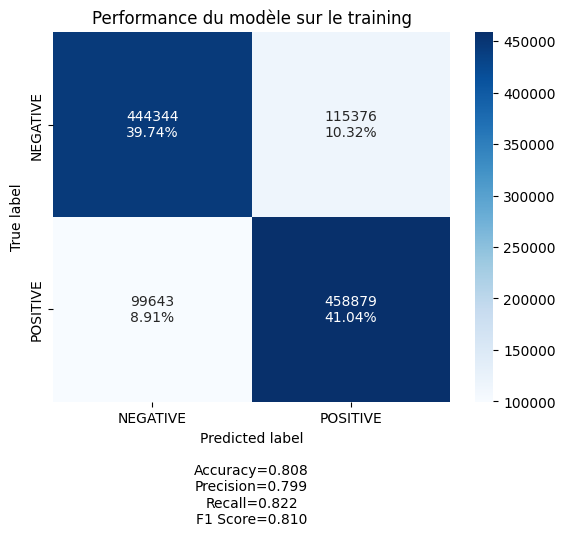

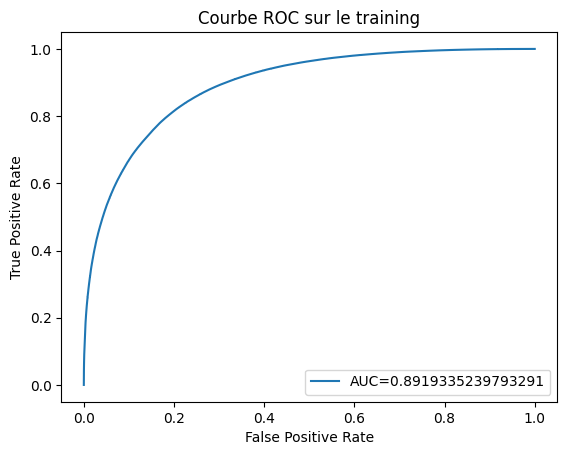

In [48]:
analyse_performance_model(model_nn,X_train,y_train,"training")

10035/10035 [==============================] - 126s 13ms/step


<Figure size 640x480 with 0 Axes>

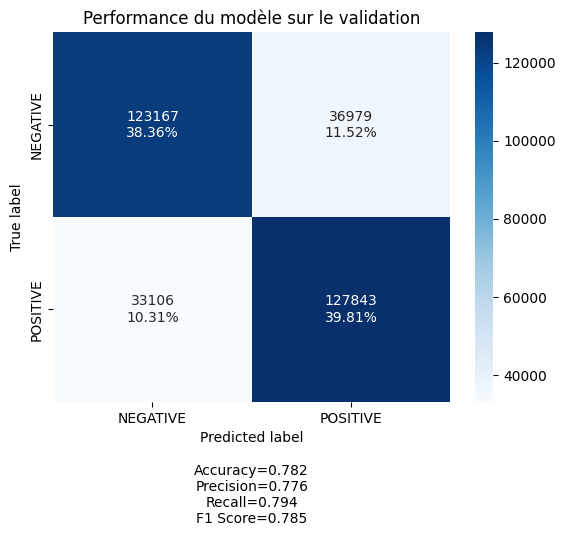

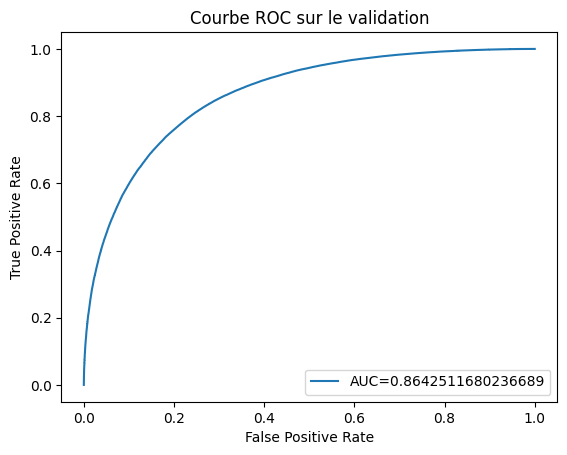

In [49]:
analyse_performance_model(model_nn,X_val,y_val,"validation")

4943/4943 [==============================] - 61s 12ms/step


<Figure size 640x480 with 0 Axes>

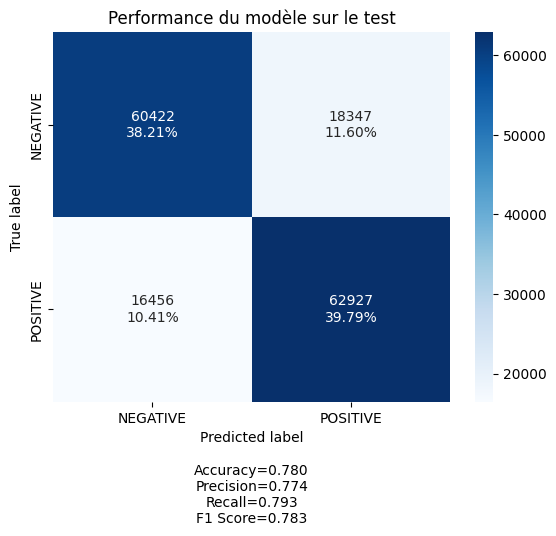

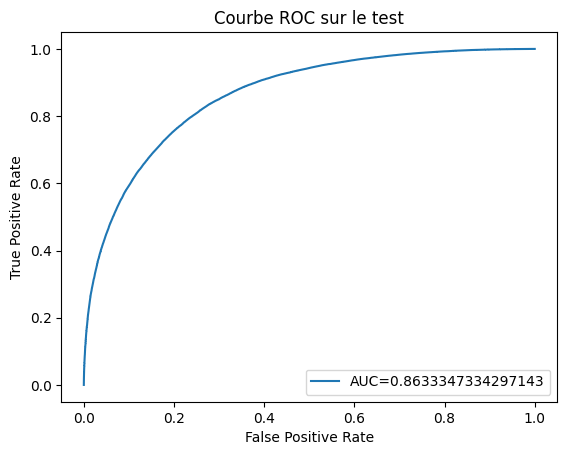

In [50]:
analyse_performance_model(model_nn,X_test,y_test,"test")

**Glove LSTM model**

In [41]:
# Hyperparamer tuner
glove_layer = Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)
glove_hypermodel = MyHyperModel("lstm_glove_embedding", glove_layer,"LSTM")
glove_tuner = BayesianOptimization(glove_hypermodel, objective='val_accuracy', max_trials=10)
glove_tuner.search(X_train, y_train, epochs=3, validation_data=(X_val, y_val), batch_size=1024)


Trial 10 Complete [00h 06m 15s]
val_accuracy: 0.7574175596237183

Best val_accuracy So Far: 0.7646552920341492
Total elapsed time: 01h 18m 35s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_model = glove_tuner.get_best_models(num_models=1)[0]
best_hyperparameters = glove_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)
best_model.summary()

{'units_lstm': 80, 'units_dense_': 30, 'optimizer': 'Adam'}
Model: "lstm_glove_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         69783500  
                                                                 
 lstm (LSTM)                 (None, 80)                57920     
                                                                 
 dense (Dense)               (None, 30)                2430      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 69,843,881
Trainable params: 60,381
Non-trainable params: 69,783,500
_________________________________________________________________


In [45]:
model_save_path = os.path.join(results_data_path, "best_glove_lstm.h5")
best_model.save(model_save_path)

34946/34946 [==============================] - 281s 8ms/step


<Figure size 640x480 with 0 Axes>

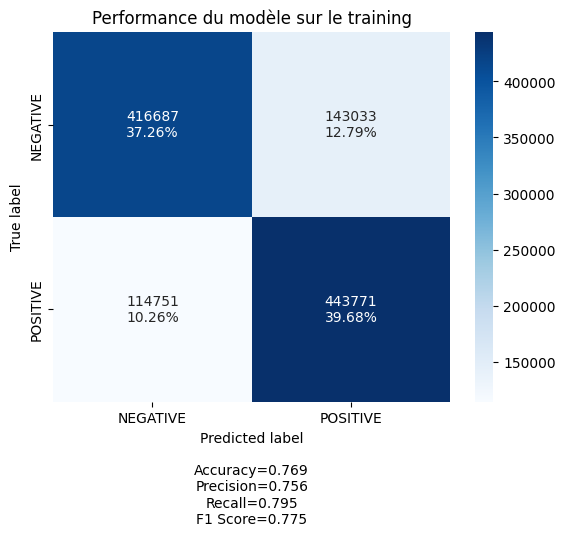

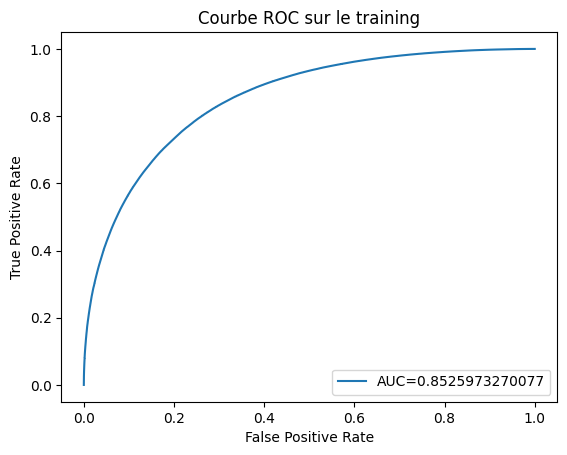

In [31]:
analyse_performance_model(best_model,X_train,y_train,"training")

10035/10035 [==============================] - 78s 8ms/step


<Figure size 640x480 with 0 Axes>

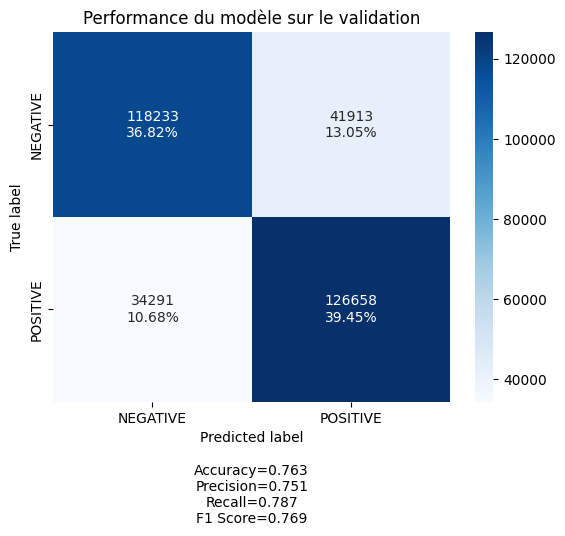

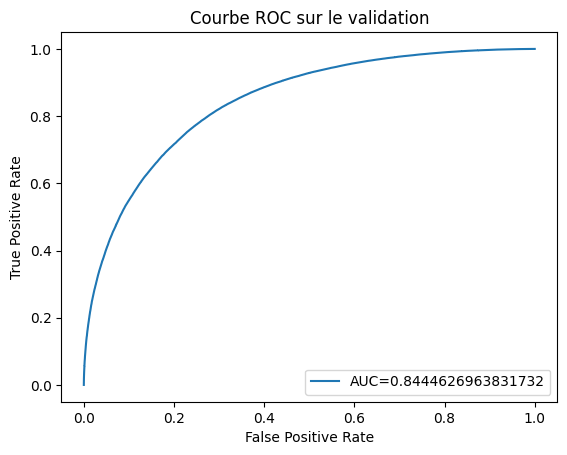

In [32]:
analyse_performance_model(best_model,X_val,y_val,"validation")

4943/4943 [==============================] - 44s 9ms/step


<Figure size 640x480 with 0 Axes>

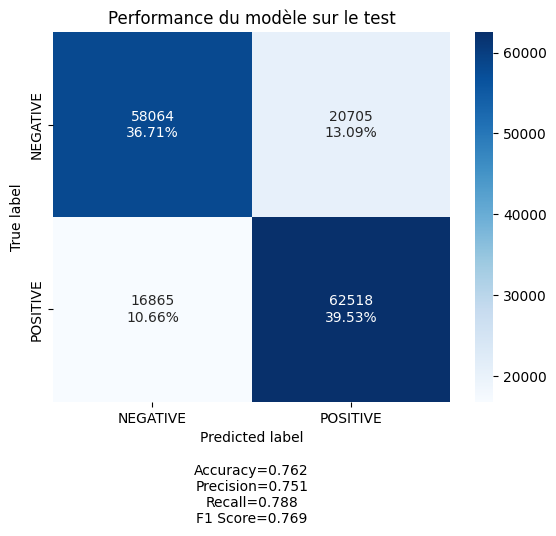

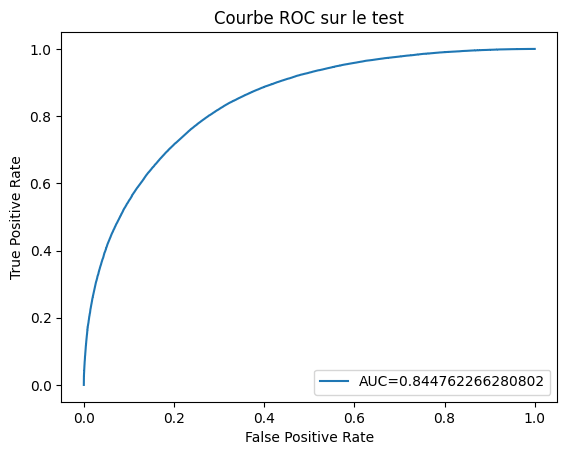

In [33]:
analyse_performance_model(best_model,X_test,y_test,"test")